In [17]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install plotly

In [18]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"

In [19]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [20]:
from google.colab import files
uploaded = files.upload()

Saving Ball_By_Ball.csv to Ball_By_Ball (1).csv
Saving Match.csv to Match (1).csv
Saving Player.csv to Player (1).csv
Saving Player_match.csv to Player_match (1).csv
Saving Team.csv to Team (1).csv


In [32]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType

ball_by_ball_schema = StructType([
    StructField("match_id", IntegerType(), True),
    StructField("inning", IntegerType(), True),
    StructField("over", IntegerType(), True),
    StructField("ball", IntegerType(), True),
    StructField("batsman", StringType(), True),
    StructField("bowler", StringType(), True),
    StructField("runs_scored", IntegerType(), True),
    StructField("player_dismissed", StringType(), True)  # Added to account for wickets
    # Add all necessary fields
])

ball_by_ball_df = spark.read.schema(ball_by_ball_schema).csv("Ball_By_Ball.csv", header=True)
match_df = spark.read.csv("Match.csv", header=True)
player_df = spark.read.csv("Player.csv", header=True)
team_df = spark.read.csv("Team.csv", header=True)

# Display DataFrames
ball_by_ball_df.show(5)
match_df.show(5)
player_df.show(5)
team_df.show(5)

+--------+------+----+----+-------+------+-----------+----------------+
|match_id|inning|over|ball|batsman|bowler|runs_scored|player_dismissed|
+--------+------+----+----+-------+------+-----------+----------------+
|  598028|    15|   6|   1|      5|     2|          6|       No Extras|
|  598028|    14|   1|   1|      5|     2|          5|       No Extras|
|  598028|    14|   2|   1|      5|     2|          3|       No Extras|
|  598028|    14|   3|   1|      5|     2|          5|       No Extras|
|  598028|    14|   4|   1|      5|     2|          3|       No Extras|
+--------+------+----+----+-------+------+-----------+----------------+
only showing top 5 rows

+--------+--------+--------------------+--------------------+----------+-----------+--------------------+----------+------------+--------------------+--------------------+---------+--------+------------+-----------+----------+----------+
|Match_SK|match_id|               Team1|               Team2|match_date|Season_Year|     

In [33]:
# Drop rows with null values
ball_by_ball_df = ball_by_ball_df.na.drop()
match_df = match_df.na.drop()
player_df = player_df.na.drop()
team_df = team_df.na.drop()

# Convert data types if necessary
ball_by_ball_df = ball_by_ball_df.withColumn("match_id", ball_by_ball_df["match_id"].cast(IntegerType()))
ball_by_ball_df.show()

+--------+------+----+----+-------+------+-----------+----------------+
|match_id|inning|over|ball|batsman|bowler|runs_scored|player_dismissed|
+--------+------+----+----+-------+------+-----------+----------------+
|  598028|    15|   6|   1|      5|     2|          6|       No Extras|
|  598028|    14|   1|   1|      5|     2|          5|       No Extras|
|  598028|    14|   2|   1|      5|     2|          3|       No Extras|
|  598028|    14|   3|   1|      5|     2|          5|       No Extras|
|  598028|    14|   4|   1|      5|     2|          3|       No Extras|
|  598028|    14|   5|   1|      5|     2|          3|       No Extras|
|  598028|    14|   6|   1|      5|     2|          3|       No Extras|
|  598028|    13|   1|   1|      5|     2|          5|       No Extras|
|  598028|    13|   2|   1|      5|     2|          3|       No Extras|
|  598028|    13|   3|   1|      5|     2|          3|       No Extras|
|  598028|    13|   4|   1|      5|     2|          5|       No 

In [34]:
ball_by_ball_df.createOrReplaceTempView("ball_by_ball")
match_df.createOrReplaceTempView("match")
player_df.createOrReplaceTempView("player")
team_df.createOrReplaceTempView("team")

In [35]:
top_scorers = spark.sql("""
    SELECT batsman, SUM(runs_scored) as total_runs
    FROM ball_by_ball
    GROUP BY batsman
    ORDER BY total_runs DESC
    LIMIT 10
""")
top_scorers.show()

+-------+----------+
|batsman|total_runs|
+-------+----------+
|      7|     61308|
|      4|     59390|
|      6|     57678|
|      2|     56231|
|      3|     53474|
|      1|     53291|
|      5|     49607|
|      8|     33153|
|     11|     25880|
|     10|     21677|
+-------+----------+



In [36]:
top_bowlers = spark.sql("""
    SELECT bowler, COUNT(player_dismissed) as wickets
    FROM ball_by_ball
    WHERE player_dismissed IS NOT NULL
    GROUP BY bowler
    ORDER BY wickets DESC
    LIMIT 10
""")
top_bowlers.show()

+------+-------+
|bowler|wickets|
+------+-------+
|     7|  16704|
|     2|  16416|
|     4|  15776|
|     1|  15585|
|     6|  15534|
|     3|  15493|
|     5|  14177|
|     8|   9038|
|    11|   7276|
|    10|   5457|
+------+-------+



In [37]:
match_outcomes = spark.sql("""
    SELECT match_id, Team1 as team1, Team2 as team2, match_winner as winner
    FROM match
""")
match_outcomes.show()

+--------+--------------------+--------------------+--------------------+
|match_id|               team1|               team2|              winner|
+--------+--------------------+--------------------+--------------------+
|  335987|Royal Challengers...|Kolkata Knight Ri...|Kolkata Knight Ri...|
|  335988|     Kings XI Punjab| Chennai Super Kings| Chennai Super Kings|
|  335989|    Delhi Daredevils|    Rajasthan Royals|    Delhi Daredevils|
|  335990|      Mumbai Indians|Royal Challengers...|Royal Challengers...|
|  335991|Kolkata Knight Ri...|     Deccan Chargers|Kolkata Knight Ri...|
|  335992|    Rajasthan Royals|     Kings XI Punjab|    Rajasthan Royals|
|  335993|     Deccan Chargers|    Delhi Daredevils|    Delhi Daredevils|
|  335994| Chennai Super Kings|      Mumbai Indians| Chennai Super Kings|
|  335995|     Deccan Chargers|    Rajasthan Royals|    Rajasthan Royals|
|  335996|     Kings XI Punjab|      Mumbai Indians|     Kings XI Punjab|
|  335997|Royal Challengers...|    Raj

In [40]:
import plotly.express as px
#to visualize top scorers
top_scorers_pd = top_scorers.toPandas()
fig = px.bar(top_scorers_pd, x='batsman', y='total_runs', title='Top 10 Batsmen by Runs Scored')
fig.show()

In [41]:
#to visualize top bowlers
top_bowlers_pd = top_bowlers.toPandas()
fig = px.bar(top_bowlers_pd, x='bowler', y='wickets', title='Top 10 Bowlers by Wickets Taken')
fig.show()

In [42]:
#to visualize match outcomes AKA the winning team
match_outcomes_pd = match_outcomes.toPandas()
fig = px.histogram(match_outcomes_pd, x='winner', title='Match Outcomes by Team')
fig.show()

In [45]:
# Standard deviation of runs scored by top batsmen
consistency = spark.sql("""
    SELECT batsman, STDDEV(runs_scored) as stddev_runs
    FROM ball_by_ball
    GROUP BY batsman
    ORDER BY stddev_runs ASC
    LIMIT 10
""")
consistency.show()

+-------+------------------+
|batsman|       stddev_runs|
+-------+------------------+
|     12|1.8031548000398003|
|      3|1.9754369060069117|
|      8|2.0758041678765267|
|      1|2.0993691636190146|
|      2| 2.123412778263377|
|      7|2.1316191534671725|
|      6|2.1360605510753943|
|     11| 2.186368290956124|
|     13|2.2055039155887854|
|      4| 2.238802612262343|
+-------+------------------+



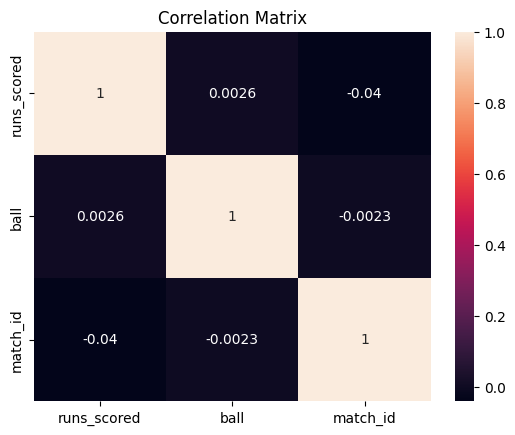

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation heatmap
metrics_df = ball_by_ball_df.select('runs_scored', 'ball', 'match_id').toPandas()
correlation_matrix = metrics_df.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation Matrix')
plt.show()

In [49]:
avg_runs_per_season = spark.sql("""
    SELECT Season_Year, AVG(total_runs) as avg_runs
    FROM (
        SELECT match.match_id, match.Season_Year, SUM(ball_by_ball.runs_scored) as total_runs
        FROM ball_by_ball
        JOIN match ON ball_by_ball.match_id = match.match_id
        GROUP BY match.match_id, match.Season_Year
    ) t
    GROUP BY Season_Year
    ORDER BY Season_Year
""")
avg_runs_per_season.show()

+-----------+-----------------+
|Season_Year|         avg_runs|
+-----------+-----------------+
|       2008|847.5172413793103|
|       2009|902.2982456140351|
|       2010|           892.65|
|       2011|826.3972602739726|
|       2012|848.0675675675676|
|       2013|870.0394736842105|
|       2014|            831.3|
|       2015|821.1016949152543|
|       2016|796.8833333333333|
+-----------+-----------------+



In [50]:
import plotly.express as px

avg_runs_per_season_pd = avg_runs_per_season.toPandas()
fig = px.line(avg_runs_per_season_pd, x='Season_Year', y='avg_runs', title='Average Runs per Match per Season')
fig.show()

In [51]:
# Calculate strike rates for batsmen
strike_rates = spark.sql("""
    SELECT batsman, SUM(runs_scored) / COUNT(ball) * 100 as strike_rate
    FROM ball_by_ball
    GROUP BY batsman
    ORDER BY strike_rate DESC
    LIMIT 10
""")
strike_rates.show()

# Scatter plot for strike rates
strike_rates_pd = strike_rates.toPandas()
fig = px.scatter(strike_rates_pd, x='batsman', y='strike_rate', title='Top 10 Batsmen by Strike Rate')
fig.show()

+-------+------------------+
|batsman|       strike_rate|
+-------+------------------+
|     10| 398.2546389858534|
|     13|379.74616604970913|
|      6|  372.572831212454|
|      9|372.37673830594184|
|      4| 371.3964104808955|
|      8| 367.0209232813019|
|      7| 360.8900400282552|
|      5|358.30263633080534|
|     11| 350.7250304919366|
|      2| 348.3952912019827|
+-------+------------------+



In [53]:
match_outcomes = spark.sql("""
    SELECT match_winner as winner, COUNT(*) as count
    FROM match
    GROUP BY match_winner
""")
match_outcomes.show()
match_outcomes_pd = match_outcomes.toPandas()
fig = px.pie(match_outcomes_pd, values='count', names='winner', title='Match Outcomes by Team')
fig.show()

+--------------------+-----+
|              winner|count|
+--------------------+-----+
| Sunrisers Hyderabad|   42|
| Chennai Super Kings|   79|
|     Deccan Chargers|   29|
|Kochi Tuskers Kerala|    6|
|    Rajasthan Royals|   63|
|       Gujarat Lions|   13|
|Royal Challengers...|   73|
|Kolkata Knight Ri...|   77|
|Rising Pune Super...|   15|
|     Kings XI Punjab|   70|
|       Pune Warriors|   12|
|    Delhi Daredevils|   62|
|      Mumbai Indians|   91|
|                NULL|    3|
+--------------------+-----+



In [54]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

# Example: Predicting runs scored
features = ['over', 'ball', 'inning']
assembler = VectorAssembler(inputCols=features, outputCol='features')
data = assembler.transform(ball_by_ball_df)

lr = LinearRegression(featuresCol='features', labelCol='runs_scored')
model = lr.fit(data)
predictions = model.transform(data)
predictions.select('over', 'ball', 'inning', 'runs_scored', 'prediction').show()

+----+----+------+-----------+------------------+
|over|ball|inning|runs_scored|        prediction|
+----+----+------+-----------+------------------+
|   6|   1|    15|          6| 4.863528671084393|
|   1|   1|    14|          5| 4.314083249209755|
|   2|   1|    14|          3|4.3741031584424865|
|   3|   1|    14|          5| 4.434123067675217|
|   4|   1|    14|          3|4.4941429769079475|
|   5|   1|    14|          3| 4.554162886140679|
|   6|   1|    14|          3| 4.614182795373409|
|   1|   1|    13|          5|4.0647373734987715|
|   2|   1|    13|          3| 4.124757282731503|
|   3|   1|    13|          3| 4.184777191964233|
|   4|   1|    13|          5| 4.244797101196964|
|   5|   1|    13|          5| 4.304817010429695|
|   6|   1|    13|          5| 4.364836919662426|
|   1|   1|    12|          3| 3.815391497787788|
|   2|   1|    12|          5|3.8754114070205183|
|   3|   1|    12|          5| 3.935431316253249|
|   4|   1|    12|          3|  3.99545122548598|


In [66]:
#preparing data for clustering
player_performance = spark.sql("""
    SELECT batsman as player, SUM(runs_scored) as total_runs, COUNT(ball) as balls_faced, 0 as total_wickets, 0 as balls_bowled
    FROM ball_by_ball
    GROUP BY batsman
    UNION
    SELECT bowler as player, 0 as total_runs, 0 as balls_faced, COUNT(player_dismissed) as total_wickets, COUNT(ball) as balls_bowled
    FROM ball_by_ball
    WHERE player_dismissed IS NOT NULL
    GROUP BY bowler
""")
player_performance = player_performance.na.fill(0)
player_performance.show()

+------+----------+-----------+-------------+------------+
|player|total_runs|balls_faced|total_wickets|balls_bowled|
+------+----------+-----------+-------------+------------+
|    12|      4728|       1580|            0|           0|
|     8|     33153|       9033|            0|           0|
|    10|         0|          0|         5457|        5457|
|     1|     53291|      15416|            0|           0|
|     5|         0|          0|        14177|       14177|
|     4|     59390|      15991|            0|           0|
|     2|         0|          0|        16416|       16416|
|     6|         0|          0|        15534|       15534|
|    10|     21677|       5443|            0|           0|
|     4|         0|          0|        15776|       15776|
|     9|         0|          0|         1614|        1614|
|    13|      7181|       1891|            0|           0|
|    11|         0|          0|         7276|        7276|
|    11|     25880|       7379|            0|           

In [67]:
#feature-assembling for clustering
assembler = VectorAssembler(inputCols=["total_runs", "balls_faced", "total_wickets", "balls_bowled"],
                            outputCol="features")
player_performance = assembler.transform(player_performance)
player_performance.show()

+------+----------+-----------+-------------+------------+--------------------+
|player|total_runs|balls_faced|total_wickets|balls_bowled|            features|
+------+----------+-----------+-------------+------------+--------------------+
|    12|      4728|       1580|            0|           0|[4728.0,1580.0,0....|
|     8|     33153|       9033|            0|           0|[33153.0,9033.0,0...|
|    10|         0|          0|         5457|        5457|[0.0,0.0,5457.0,5...|
|     1|     53291|      15416|            0|           0|[53291.0,15416.0,...|
|     5|         0|          0|        14177|       14177|[0.0,0.0,14177.0,...|
|     4|     59390|      15991|            0|           0|[59390.0,15991.0,...|
|     2|         0|          0|        16416|       16416|[0.0,0.0,16416.0,...|
|     6|         0|          0|        15534|       15534|[0.0,0.0,15534.0,...|
|    10|     21677|       5443|            0|           0|[21677.0,5443.0,0...|
|     4|         0|          0|        1

In [68]:
#k-means method for clustering
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

kmeans = KMeans(k=3, seed=42)
model = kmeans.fit(player_performance)

predictions = model.transform(player_performance)

evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print(f"Silhouette with squared euclidean distance = {silhouette}")

predictions.select("player", "prediction").show()

Silhouette with squared euclidean distance = 0.7251160240076164
+------+----------+
|player|prediction|
+------+----------+
|    12|         1|
|     8|         0|
|    10|         1|
|     1|         0|
|     5|         2|
|     4|         0|
|     2|         2|
|     6|         2|
|    10|         1|
|     4|         2|
|     9|         1|
|    13|         1|
|    11|         1|
|    11|         1|
|     1|         2|
|     6|         0|
|     5|         0|
|     9|         1|
|     8|         2|
|    12|         1|
+------+----------+
only showing top 20 rows



In [69]:
# Select relevant columns and convert to Pandas DataFrame
clustering_results_pd = predictions.select("player", "total_runs", "balls_faced", "total_wickets", "balls_bowled", "prediction").toPandas()

In [70]:
import plotly.express as px

# Scatter plot for clustering results
fig = px.scatter(clustering_results_pd, x="total_runs", y="total_wickets", color="prediction", hover_data=["player"],
                 title="Player Clustering Based on Performance")
fig.show()

In [72]:
#for classification models
match_df.columns

['Team1', 'Team2', 'Season_Year', 'Venue_Name', 'Toss_Winner', 'label']

In [73]:
#prepare data for classification
match_df = match_df.withColumnRenamed("Correct_Match_Winner_Column_Name", "match_winner") \
                   .withColumnRenamed("Correct_Team1_Column_Name", "Team1") \
                   .withColumnRenamed("Correct_Team2_Column_Name", "Team2") \
                   .withColumnRenamed("Correct_Season_Year_Column_Name", "Season_Year") \
                   .withColumnRenamed("Correct_Venue_Name_Column_Name", "Venue_Name") \
                   .withColumnRenamed("Correct_Toss_Winner_Column_Name", "Toss_Winner")

In [75]:
match_df.columns
match_df.show(10)

+--------------------+--------------------+-----------+--------------------+--------------------+-----+
|               Team1|               Team2|Season_Year|          Venue_Name|         Toss_Winner|label|
+--------------------+--------------------+-----------+--------------------+--------------------+-----+
|Royal Challengers...|Kolkata Knight Ri...|       2008|M Chinnaswamy Sta...|Royal Challengers...|    0|
|     Kings XI Punjab| Chennai Super Kings|       2008|Punjab Cricket As...| Chennai Super Kings|    0|
|    Delhi Daredevils|    Rajasthan Royals|       2008|    Feroz Shah Kotla|    Rajasthan Royals|    1|
|      Mumbai Indians|Royal Challengers...|       2008|    Wankhede Stadium|      Mumbai Indians|    0|
|Kolkata Knight Ri...|     Deccan Chargers|       2008|        Eden Gardens|     Deccan Chargers|    1|
|    Rajasthan Royals|     Kings XI Punjab|       2008|Sawai Mansingh St...|     Kings XI Punjab|    1|
|     Deccan Chargers|    Delhi Daredevils|       2008|Rajiv Gan

In [76]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

# Index string columns
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in ["Team1", "Team2", "Venue_Name", "Toss_Winner"]]

# Apply OneHotEncoder to indexed columns
encoder = OneHotEncoder(inputCols=["Team1_index", "Team2_index", "Venue_Name_index", "Toss_Winner_index"],
                        outputCols=["Team1_vec", "Team2_vec", "Venue_vec", "Toss_Winner_vec"])

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=["Team1_vec", "Team2_vec", "Venue_vec", "Toss_Winner_vec"],
                            outputCol="features")

# Create a pipeline for transformations
pipeline = Pipeline(stages=indexers + [encoder, assembler])
match_df = pipeline.fit(match_df).transform(match_df)
match_df.show()

+--------------------+--------------------+-----------+--------------------+--------------------+-----+-----------+-----------+----------------+-----------------+--------------+--------------+--------------+---------------+--------------------+
|               Team1|               Team2|Season_Year|          Venue_Name|         Toss_Winner|label|Team1_index|Team2_index|Venue_Name_index|Toss_Winner_index|     Team1_vec|     Team2_vec|     Venue_vec|Toss_Winner_vec|            features|
+--------------------+--------------------+-----------+--------------------+--------------------+-----+-----------+-----------+----------------+-----------------+--------------+--------------+--------------+---------------+--------------------+
|Royal Challengers...|Kolkata Knight Ri...|       2008|M Chinnaswamy Sta...|Royal Challengers...|    0|        0.0|        1.0|             0.0|              3.0|(12,[0],[1.0])|(12,[1],[1.0])|(36,[0],[1.0])| (13,[3],[1.0])|(73,[0,13,24,63],...|
|     Kings XI Punja

In [77]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Split the data into training and test sets
train, test = match_df.randomSplit([0.7, 0.3], seed=42)

# Initialize the logistic regression model
lr = LogisticRegression(featuresCol="features", labelCol="label")

# Define the evaluator
evaluator = BinaryClassificationEvaluator(labelCol="label")

# Set up parameter grid for cross-validation
paramGrid = ParamGridBuilder().addGrid(lr.regParam, [0.1, 0.01]).build()

# Set up cross-validation
crossval = CrossValidator(estimator=lr, evaluator=evaluator, estimatorParamMaps=paramGrid, numFolds=3)

# Fit the model
cvModel = crossval.fit(train)

# Make predictions on the test data
predictions = cvModel.transform(test)

# Evaluate the model
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")
predictions.select("label", "prediction").show()

Accuracy: 0.5890643447461626
+-----+----------+
|label|prediction|
+-----+----------+
|    0|       1.0|
|    1|       1.0|
|    0|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       0.0|
|    1|       1.0|
|    1|       1.0|
|    0|       1.0|
|    0|       0.0|
|    0|       1.0|
|    0|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    0|       1.0|
|    1|       1.0|
+-----+----------+
only showing top 20 rows

